# Overview
This is my attempt to solve the first assignment of the Introduction to Machine Learning course, fall 2022.
## Note
Please make sure the dataset is saved in the same working directory as this notebook.
  
Please note that further in this notebook I will use the term ***f $i$*** to refer to the column ***var $i$***

# Preliminary: imports and Loading data

In [29]:
# main imports needed for the rest of the notebook
import os
import math
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
# setting seaborn to darkgrid for a more detailed display of the values
STYLE = 'darkgrid'
sns.set_style(STYLE)

RANDOM_STATE = 11

import warnings
warnings.filterwarnings('ignore')

In [30]:
wd = os.getcwd()
dataset_name = "a1_dataset.csv"
file_path = os.path.join(wd, dataset_name) # setting the location of the file 

In [31]:
df_org = pd.read_csv(file_path) # save original datafrae 
df = df_org.copy() # copy to work on

In [32]:
# let's rename the columns
new_names = {"target": "y"}
y = df['target']
for i in range(1, len(df.columns) + 1):
    new_names[f'var{str(i)}'] = f"f{str(i)}"
df = df.rename(columns=new_names)
print(df.columns)
# I will drop the target column and add it to the dataframe when needed
df.drop('y', inplace=True, axis=1)

Index(['y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], dtype='object')


# Preprocessing
In this part I preprocess the data for the training phase:
* distinguish between numerical and categorial data
* clean certain columns
* encode categorical features
* impute missing vaues

In [33]:
# this method returns a tuple of the column names : numerical then categorical
def num_cat(df):
    num = df.select_dtypes(np.number).columns.values
    cat = df.select_dtypes(['object', 'category']).columns.values
    return num, cat

num_cols, cat_cols = num_cat(df)

## Cleaning data
Let's start cleaning by fixing the 'var7' column.

In [34]:
# let's set the last column to datetime for further manipulation
try:    
    df['f7'] = pd.to_datetime(df['f7']) 
except:
    print("Certain dates are semantically invalid")
    
from dateutil import parser

# for futher manipulation we need to determine the invalid dates
def validate_dates(row):
    try:
        row['valid_date'] = parser.parse(row['f7']) # if the data isinvalid an error will raise,
    except ValueError:
        row['valid_date'] = False # the except block will catch it and set the field to False
    return row

df = df.apply(validate_dates, axis=1)
invalid_dates = df[df['valid_date'] == False]['f7'].values
# drop the additional column
df.drop('valid_date', axis=1, inplace=True)

Certain dates are semantically invalid


In [35]:
print(invalid_dates) # this is the list of invalid dates in the dataframes
# let's reduce these dates by 24 hours

def fix_dates(row):
    if row['f7'] in invalid_dates:
        date, time = row['f7'].split()
        # change the 29 to 28
        date = date[:-2] + "28"
        row['f7'] = date + " " + time
    return row

df = df.apply(fix_dates, axis=1)

df['f7'] = pd.to_datetime(df['f7'])

['2019-02-29 12:31:57' '2019-02-29 18:06:21' '2019-02-29 11:00:06'
 '2019-02-29 23:56:06' '2019-02-29 19:26:35']


In [36]:
print(df.dtypes)
# now that the 7th column is converted to datetime, we can futher break it down and tackle each component of the date: year, month, day, time
year = 'year'
month = 'month'
day = 'day'
time = 'time'
date_cols = [year, month, day, time]
def decompose_date(row):
    row[year] = row['f7'].year
    row[month] = row['f7'].month
    row[day] = row['f7'].day
    row[time] = row['f7'].time
    return row

df = df.apply(decompose_date, axis=1)

f1           float64
f2           float64
f3            object
f4           float64
f5           float64
f6            object
f7    datetime64[ns]
dtype: object


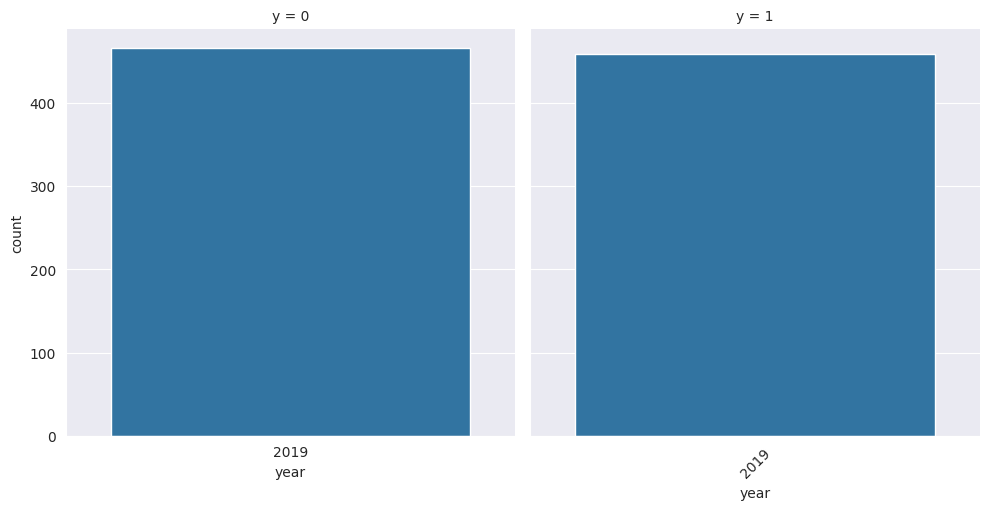

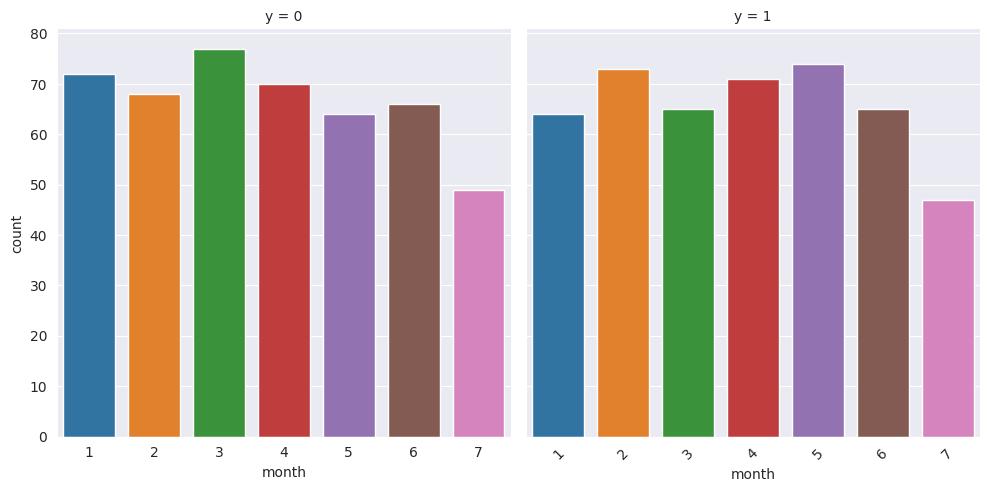

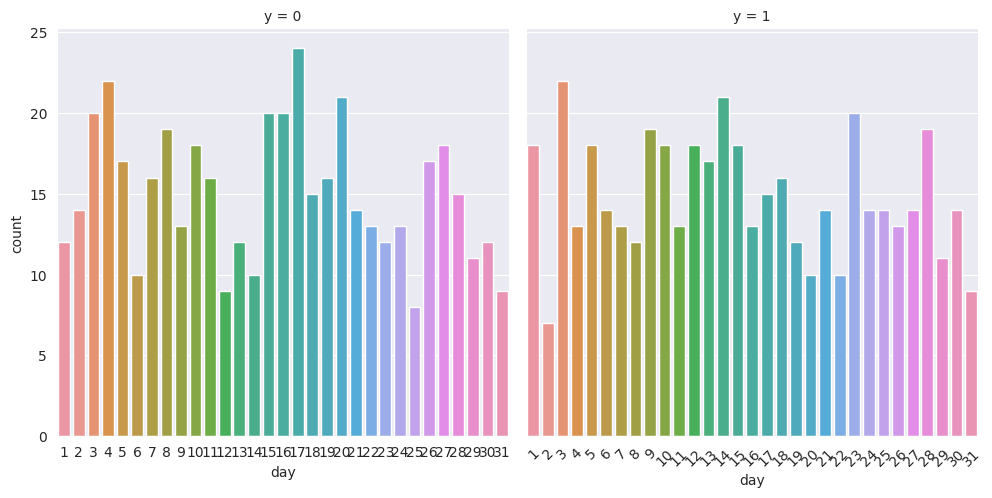

In [37]:
for c in date_cols[:-1]: # the time column has a significantly large number of unique values.
    df_c = df.copy()
    df_c['y'] = y
    fig = sns.catplot(data=df_c, kind='count', x=c, col='y', col_order=[0, 1])
    fig.set(xlabel=c, ylabel='count')
    plt.xticks(rotation=45)
    plt.show()

These are my observations:
* there is only one year present in all dates: 2019. The year can be dropped then
* The dataset is clearly not a time-series dataset where each second, minute or even hour is important, so the time part can be dropped as well

There are two main options left:
1. keep the date as month + day.
2. reduce the date to the month value.

In [38]:
f7_drop = ['f7', 'time', 'year']
for t in f7_drop:
    df.drop(t, axis=1, inplace=True)

In [39]:
# let's investigate the first option: keep the date as day and month 
def set_date(row):
    row['date'] = pd.Timestamp(year=2019, month=row[month], day=row[day])
    return row

df = df.apply(set_date, axis=1) 
# sort the dataframe by date
df = df.sort_values(by='date', ascending=True)
print(df)

         f1       f2           f3     f4      f5   f6  month  day       date
754  467.20  599.985    Mauritius    NaN  376.60   no      1    1 2019-01-01
445  423.66  634.976         Guam    NaN  393.85  yes      1    1 2019-01-01
653  391.78  428.383       Uganda    NaN  182.80  yes      1    1 2019-01-01
500  479.88  608.030      Bermuda    NaN  404.70  yes      1    1 2019-01-01
544  272.36  658.567     Ethiopia    NaN  233.05  yes      1    1 2019-01-01
..      ...      ...          ...    ...     ...  ...    ...  ...        ...
101  224.38  602.235   Martinique  126.0  309.40   no      7   23 2019-07-23
342  324.10  669.803        Ghana    NaN  393.80  yes      7   23 2019-07-23
553  326.10  643.958    Singapore    NaN  372.05  yes      7   23 2019-07-23
502  301.68  240.301  Afghanistan    NaN  400.15  yes      7   23 2019-07-23
121  225.44  364.249       Cyprus  138.0  345.75  yes      7   24 2019-07-24

[925 rows x 9 columns]


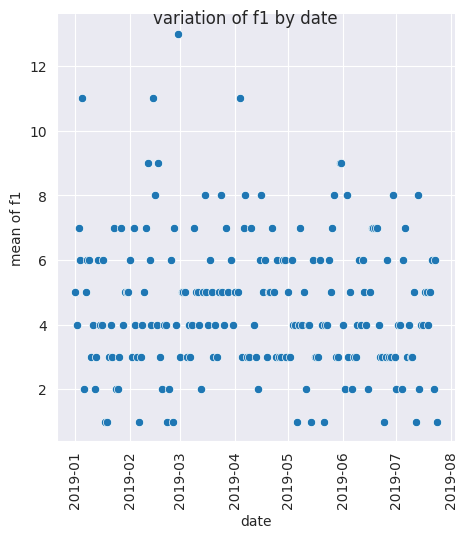

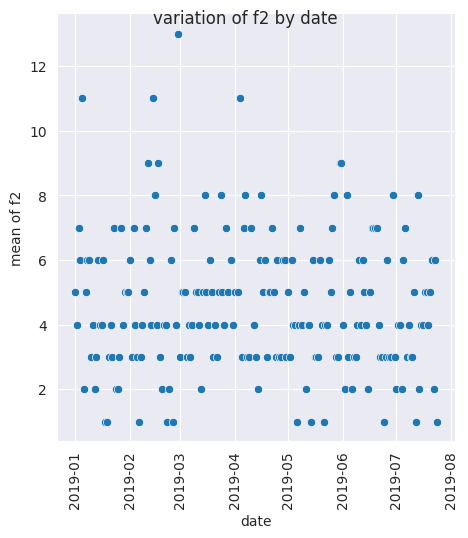

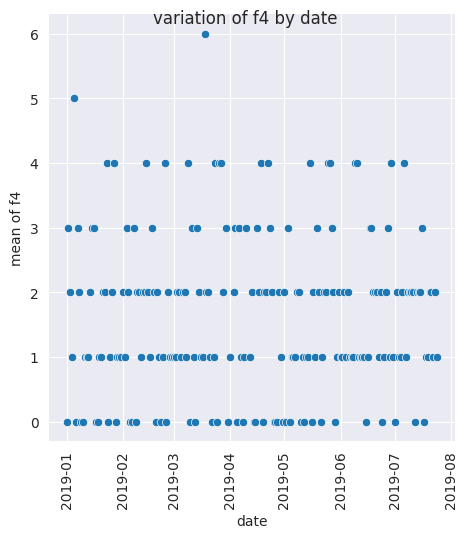

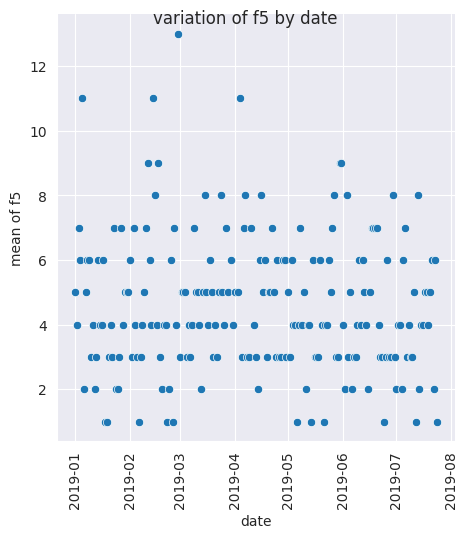

In [40]:
# time to consider the different interactions between the date and the rest of the columns
num_cols, cat_cols = num_cat(df)

for col in num_cols[:-2]:
    col_by_date = pd.pivot_table(df, index='date', values=col, aggfunc=['count', 'mean', 'median'])
    g = sns.relplot(kind='scatter', x=col_by_date.index.values, y=col_by_date[('count', col)].values)
    g.fig.suptitle(f"variation of {col} by date")
    g.set(xlabel='date', ylabel=f'mean of {col}')
    plt.xticks(rotation = 90)
    plt.show()

In [41]:
# it might be more efficient to consider the day of the year
def set_day_of_year(row):
    date = pd.Timestamp(year=2019, month=row[month], day=row[day])
    row['day_of_year'] = (date - pd.Timestamp(year=2019, month=1, day=1)).days + 1
    return row

df = df.apply(set_day_of_year, axis=1)

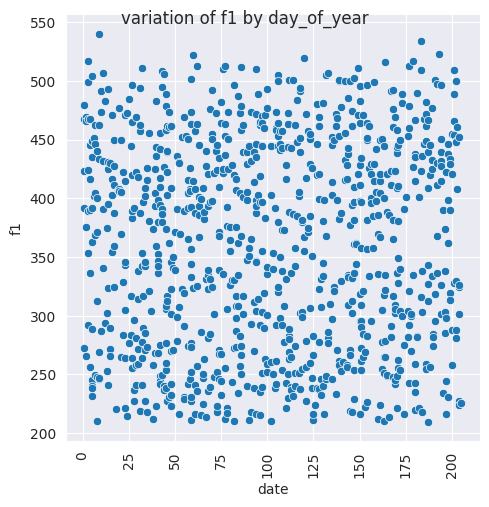

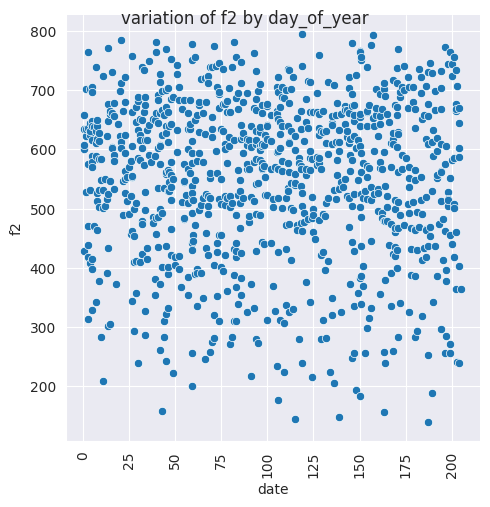

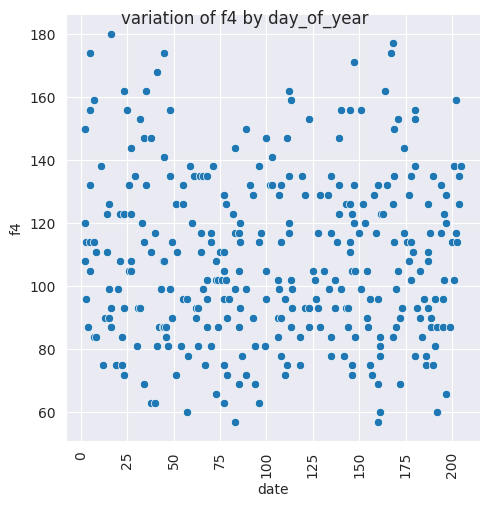

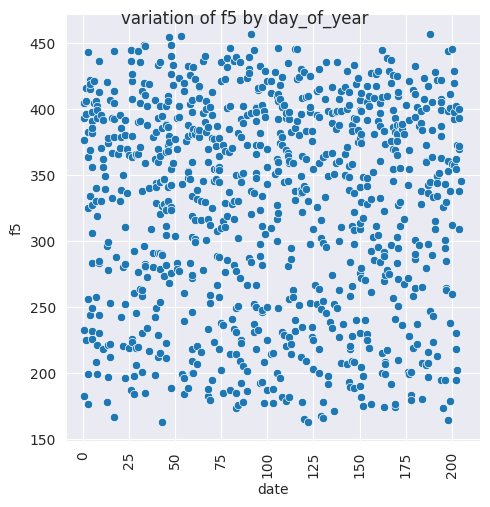

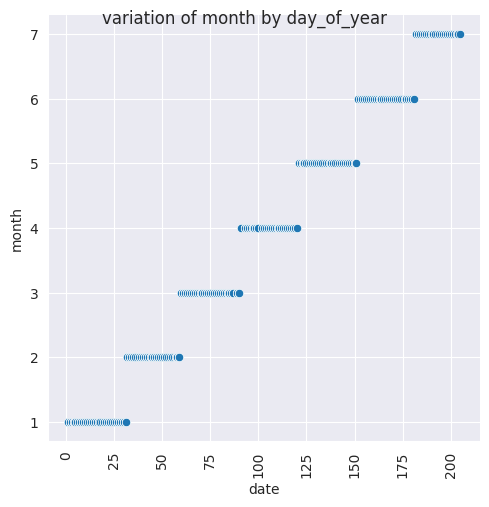

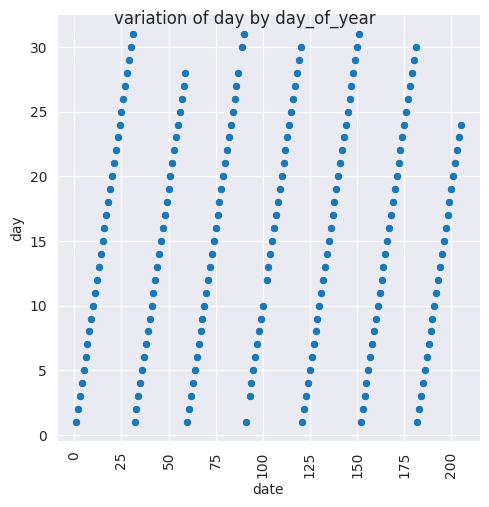

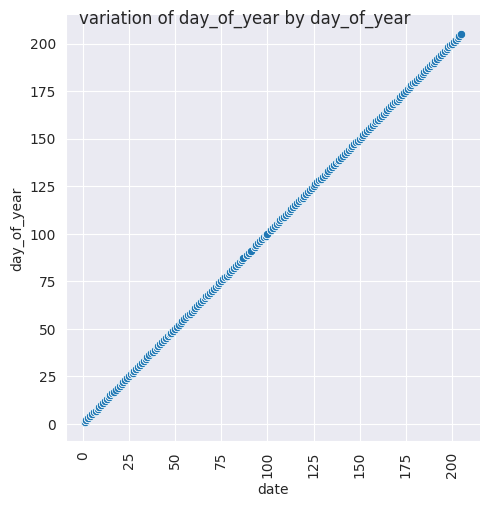

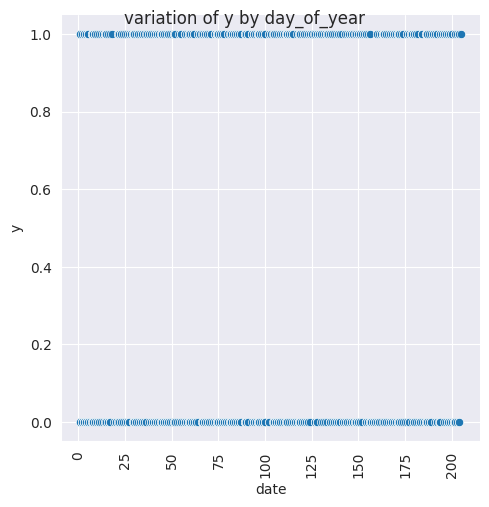

In [42]:
df['y'] = y.copy()
num_cols, cat_cols = num_cat(df)

for col in num_cols:
    g = sns.relplot(data=df, x='day_of_year', y=col)
    g.fig.suptitle(f"variation of {col} by day_of_year")
    g.set(xlabel='date', ylabel=f'{col}')
    plt.xticks(rotation = 90)
    plt.show()
df.drop('y', axis=1, inplace=True)

In [43]:
# the visualizations do not show any trend in the interacation between day_of_year and any other numerical feature or the target variable
# let's confirm that by calculating the correlation
df['y'] = y.copy()
print(df.corr()['day_of_year'])
df.drop('y', axis=1, inplace=True)
# as we can see the correlation is below 0.02

f1             0.015491
f2            -0.050410
f4            -0.009622
f5            -0.019079
month          0.988924
day            0.131636
day_of_year    1.000000
y              0.016102
Name: day_of_year, dtype: float64


Given the provided evidence it is safe to assume that the first option might not  be suitable for our data. I will use the second option: encoding the data column as its month value.

In [44]:
day_cols = ['day', 'day_of_year', 'date']
for d in day_cols: df.drop(d, axis=1, inplace=True)

## Encoding Categorical variables
It is imperative to convert the categorical variables to numerical representations before feeding them to machine learning models
### Encoding f6
Ordinal Encoder is a perfect encoding technique for f6 as the values "yes" and "no" can be ordered. The order of the numerical representations does not matter as the machine learning algorithm can assign either positive or negative signs correcting the order proposed by the encoder.

In [45]:
print(df['f6'].value_counts())
# the column has only 2 values "yes" and "no" as suggested above.
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder() # default parameters: as no customized order can be deduced from the data, the ordering is left up to the encoder
X = oe.fit_transform(df[['f6']]) # create a new dataframe where the column f6 is encoded
# create the final dataframe
df = pd.concat([df.drop('f6', axis=1), pd.DataFrame(X, columns=['f6'])], axis=1)
print(df.isna().sum())

yes    483
no     442
Name: f6, dtype: int64
f1         0
f2         0
f3         0
f4       600
f5         0
month      0
f6         0
dtype: int64


### Encoding f3: the area column:
For the f3 area, I will use the OneHot Encoding as there is no inherited order in the data. Most areas appear more than once and with different numerical values and sometimes classes. Ordinal Encoding in this case might lead to poor performance.

In [46]:
# before proceeding with the encoding, it is recommended to clean the data by normalizing the string representation and remove any possible unwanted characetrs
def clean_country(row):
    row['f3'] = row['f3'].strip().lower()
    # remove any string between parentheses if they exist
    row['f3'] = re.sub('\(.*\)', "", row['f3'])
    # remove any string between brackets if they exist
    row['f3'] = re.sub('\[.*\]', "", row['f3'])
    return row

df = df.apply(clean_country, axis=1)

In [ ]:
## ONE HOT ENCODING
df_OHE = df.copy()
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X = ohe.fit_transform(df_OHE[['f3']])
df_OHE = pd.concat([df_OHE.drop('f3', axis=1), pd.DataFrame(X, columns=ohe.get_feature_names())], axis=1)
print(df_OHE)

In [48]:
df_OE = df.copy()
oe = OrdinalEncoder() # default parameters: as no customized order can be deduced from the data, the ordering is left up to the encoder
X = oe.fit_transform(df[['f3']]) # create a new dataframe where the column f3 is encoded
# create the final dataframe
df_OE = pd.concat([df.drop('f3', axis=1), pd.DataFrame(X, columns=['f3'])], axis=1)
print(df_OE)

         f1       f2     f4      f5  month   f6     f3
754  467.20  599.985    NaN  376.60      1  0.0  111.0
445  423.66  634.976    NaN  393.85      1  0.0   35.0
653  391.78  428.383    NaN  182.80      1  1.0  122.0
500  479.88  608.030    NaN  404.70      1  1.0  116.0
544  272.36  658.567    NaN  233.05      1  1.0  173.0
..      ...      ...    ...     ...    ...  ...    ...
101  224.38  602.235  126.0  309.40      7  1.0   85.0
342  324.10  669.803    NaN  393.80      7  0.0  225.0
553  326.10  643.958    NaN  372.05      7  0.0   38.0
502  301.68  240.301    NaN  400.15      7  0.0   82.0
121  225.44  364.249  138.0  345.75      7  0.0  119.0

[925 rows x 7 columns]


#### Helper functions
In the following subsection, I create helper functions to facilate evaluating both encodings without duplicating code.

In [49]:
# prepare cross validation
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
CV = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [50]:
from sklearn.preprocessing import StandardScaler

def scale_data(df_4, df_4_t):
    # scale the training data
    scaler = StandardScaler()
    Xs = scaler.fit_transform(df_4)
    df = pd.DataFrame(Xs, columns=df_4.columns)

    # scale the test data
    Xs = scaler.transform(df_4_t)
    df_t = pd.DataFrame(Xs, columns=df_4_t.columns)
    return df, df_t 

In [51]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor as knr

SCORING = "neg_mean_squared_error"


def best_ridge(df: pd.DataFrame, y:np.array ):
    """Given a training and dataset, it will return the Ridge model with the lowest mean squared error on cross validation

    Args:
        df_4 (pd.DataFrame): the training data
        y_f4 (np.array): the training target values

    Returns:
    Ridge estimator with the alpha hyperparameter tuned
    """
    global CV, SCORING
    X_train = df.values
    
    ridge = Ridge(max_iter=5000)
    parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

    ridge_search = GridSearchCV(ridge, parameters, cv=CV, scoring=SCORING, n_jobs=-1)

    ridge_search.fit(X_train, y)

    return ridge_search.best_estimator_, -ridge_search.best_score_

def best_lasso(df: pd.DataFrame, y: np.array):
    """Given a training and dataset, it will return the Lasso model with the lowest mean squared error on cross validation

    Args:
        df_4 (pd.DataFrame): the training data
        y_f4 (np.array): the training target values

    Returns:
    Lasso estimator with the alpha hyperparameter tuned.
    """
    global CV, SCORING 
    X_train = df.values

    lasso = Lasso(max_iter=5000)
    
    parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

    lasso_search = GridSearchCV(lasso, parameters, cv=CV, scoring=SCORING, n_jobs=-1)
    lasso_search.fit(X_train, y)


    return lasso_search.best_estimator_, - lasso_search.best_score_

def best_knr(df, y):
    """Given a training and dataset, it will return the KNearestNeighbors Regressor with the lowest mean squared error on cross validation

    Args:
        df_4 (pd.DataFrame): the training data
        y_f4 (np.array): the training target values

    Returns:
    KNearestNeighbors regressor with the "K" hyperparameter tuned.
    """

    X_train = df.values

    k_reg = knr() # a default model

    # there are two main parameters to tune: number of neighbors and the type of distance

    k_reg_params = {"n_neighbors": list(range(1, 15)), "weights":['uniform', 'distance']}

    k_reg_search = GridSearchCV(k_reg, k_reg_params, cv=CV, scoring=SCORING)

    k_reg_search.fit(X_train, y)

    return k_reg_search.best_estimator_, -k_reg_search.best_score_ 

In [52]:
from sklearn.preprocessing import PolynomialFeatures

def best_poly_features(df, y, max_degree=5):
    """given the training dataset and the corresponding target values, it returns the degree for which POLYNOMIAL REGRESSION 
    performs the best

    Args:
        df_4 (DataFrame): training data
        yf4 (Series): training target values
    """
    global CV
    
    X_t = df.values
    y_t = y.values

    polys = [PolynomialFeatures(degree=i) for i in range(2, max_degree + 1)]
    X_trains = [p.fit_transform(X_t) for p in polys]    
    
    # intiate a Linear Regression model

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    print("Finding the best degree for polynomial features")
    best_score = 10 ** 9
    best_deg = 0
    scoring = "neg_mean_squared_error"
    for i in range(len(X_trains)): 
        score = -np.mean(cross_val_score(lr, X_trains[i], y_t, cv=CV, scoring=SCORING))
        print()
        print(f"best mean squared error for degree {str(i + 2)}: {str(np.mean(score))}")
        print()
        if best_score > score:
            best_score = score
            best_deg = i + 2
    
    return best_score, best_deg, polys[best_deg - 2]

def best_poly_reg(df, y, max_degree=5):
    _,_, poly = best_poly_features(df, y, max_degree)
    X_train = df.values
    # apply the best polynomial features on the training data
    X_train = poly.transform(X_train)
    
    # find the best ridge estimator with this training data
    ridge_est, ridge_score = best_ridge(pd.DataFrame(X_train), y)
    # find the best lasso estimator with this training data
    lasso_est, lasso_score = best_lasso(pd.DataFrame(X_train), y)
    
    if ridge_score > lasso_score:
        return lasso_est, poly
    return ridge_est, poly
    


In [53]:
# given a training and test dataset for prediting f4, this function will return the model that performs better the test dataset.
def best_imputation_model(df_4, df_4_t, y_f4, y_f4_t, max_poly_deg=2): 
    global CV
    df, df_t = scale_data(df_4, df_4_t)
    # we will find the best possible Ridge, Lasso, Polynomial Regularized Regression and the best KNN-R
    # each of them will be tested on the test dataset and the one with best score will be returned
    
    poly = best_poly_reg(df, y_f4, max_poly_deg)
    
    ridge = best_ridge(df, y_f4)
    lasso = best_lasso(df, y_f4)
    knn = best_knr(df, y_f4)

    X_train = df.values
    X_test = df_t.values
    models = [poly, ridge, lasso, knn]
    

    best_score = 10 ** 9
    best_model = None
    
    for m in models:
        m[0].fit(X_train, y_f4) 
        y_pred = m[0].predict(X_test)
        score = (mean_squared_error(y_pred, y_f4_t))
        print()
        print(f"The model {str(m)} achived a mean square error of {str(score)}")
        print()
        if score < best_score:
            best_model = m
            best_score = score
            
    return best_model, best_score   


##### Evaluate the encodings

In [54]:
from sklearn.model_selection import train_test_split

def divide_f4(df):
    df_f4 = df[~df['f4'].isna()]
    df_imp = df[df['f4'].isna()]
    f4 = df_f4['f4'].copy()
    df_f4.drop('f4', axis=1, inplace=True)
    df_imp.drop('f4', axis=1, inplace=True)
    
    df, df_t, y, y_t = train_test_split(df_f4, f4, test_size=0.2, random_state=RANDOM_STATE)
    return df, df_t, y, y_t, df_imp


In [59]:
# first divide the data encoded with OHE
df_HE, df_HE_t, y_HE, y_HE_t, df_HE_imp = divide_f4(df_OHE)
print("evaluate target encoding: \n")
impute_HE = best_imputation_model(df_HE, df_HE_t, y_HE, y_HE_t, max_poly_deg=2) # polynomial regression larger than 2 might lead to memory failures in the local machine

/tmp/ipykernel_13932/1415980031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f4.drop('f4', axis=1, inplace=True)
/tmp/ipykernel_13932/1415980031.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp.drop('f4', axis=1, inplace=True)


evaluate target encoding: 

Finding the best degree for polynomial features

best mean squared error for degree 2: 1107.8494439500994


The model (Lasso(alpha=100, max_iter=5000), PolynomialFeatures()) achived a mean square error of 722.8524408284026


The model (Ridge(alpha=100, max_iter=5000), 681.1723561774403) achived a mean square error of 705.2232846620211


The model (Lasso(alpha=1, max_iter=5000), 659.089927080494) achived a mean square error of 682.4613414540947


The model (KNeighborsRegressor(n_neighbors=14), 725.672669508862) achived a mean square error of 755.7117739403453



As demonstrated above the l1 regularized Polynomial Regression achieved the best performance in the test dataset. Thus it is the method of choice for imputing the missing values in the f4 column.

In [56]:
# as demonstrated by the output of the cell above the Ordinal Encoding led to better predictions.
print(impute_HE)
(lr, best_val_score), best_test_score = impute_HE


((Lasso(alpha=1, max_iter=5000), 659.089927080494), 682.4613414540947)


In [60]:
# As the entire process was masked by the functions' calls, I decided to reproduce the process with the final best model.
X_train = df_HE.values
X_test = df_HE_t.values 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr.fit(X_train, y_HE.values)
y_pred = lr.predict(X_test)

pred_test = dict(zip(y_HE_t.values, y_pred))
print(mean_squared_error(y_pred, y_HE_t))
print(pred_test)

682.4613414540947
{84.0: 100.86969669048715, 81.0: 98.25991725512728, 114.0: 116.69753486562021, 99.0: 92.97165395358738, 123.0: 92.33459337072568, 87.0: 116.49566522340926, 63.0: 104.06746255678827, 111.0: 93.89247152089268, 93.0: 102.9661806345718, 162.0: 119.77371136279419, 96.0: 95.0099312965051, 66.0: 76.36606986472097, 105.0: 95.29969271841252, 117.0: 84.66925422289411, 153.0: 85.41148028482334, 72.0: 98.35101361542289, 138.0: 136.36555072966067, 75.0: 118.39008819001192, 156.0: 112.04829210157132, 147.0: 113.47503619998785, 90.0: 95.58038632083543, 168.0: 115.9137996383395, 129.0: 120.20271886568182, 69.0: 98.33813442473297, 57.0: 109.78380529041625, 135.0: 120.22511136169167, 120.0: 102.40680129201048, 159.0: 99.03897631504398, 141.0: 114.50424597934433, 78.0: 89.93872317995914, 150.0: 110.58551891932751, 108.0: 72.21808691928949}


## Imputing the missing values

In [ ]:
# df_OE_imp.drop('f4', axis=1, inplace=True)
impute_values = lr.predict(scaler.transform(df_HE_imp.values)) 

df_HE = df_HE_org
df_HE_imp = df_HE[df_HE['f4'].isna()]
df_HE_com = df_HE[~df_OE['f4'].isna()]
df_HE_imp['f4'] = impute_values

df_HE = pd.concat([df_HE_com, df_HE_imp])
print(df_HE)

         f1       f2          f4      f5  month   f6     f3
244  375.52  702.256  120.000000  416.30      1  1.0   78.0
271  265.42  528.020  150.000000  224.80      1  1.0  112.0
35   466.08  633.944  108.000000  406.05      1  0.0   52.0
283  291.92  313.434  114.000000  199.25      1  0.0   65.0
254  423.74  438.705   96.000000  443.60      1  0.0  171.0
..      ...      ...         ...     ...    ...  ...    ...
801  461.04  707.013  104.185291  372.90      7  0.0  111.0
410  451.98  403.455   96.912962  370.30      7  0.0   41.0
342  324.10  669.803   93.017205  393.80      7  0.0  225.0
553  326.10  643.958  102.104457  372.05      7  0.0   38.0
502  301.68  240.301  125.874271  400.15      7  0.0   82.0

[925 rows x 7 columns]


/tmp/ipykernel_7239/814604316.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OE_imp['f4'] = impute_values


In [ ]:
print(df_OE['f4'].describe()) # the describtive analysis of f4 after imputing
print(df['f4'].describe()) # the describtive analysis of f4 before imputing
# as we can see the regression model does not alter the general distribution of f4 signficantly, which an indicator of good predictions,
# mainly when the new data is twice as large.

count    925.000000
mean     106.694052
std       19.929766
min       57.000000
25%       91.878892
50%      102.000000
75%      121.852986
max      180.000000
Name: f4, dtype: float64
count    325.000000
mean     108.452308
std       26.325744
min       57.000000
25%       87.000000
50%      105.000000
75%      126.000000
max      180.000000
Name: f4, dtype: float64


In [ ]:
df = df_OE.copy() # setting the df variable as the variable to work with.
print(df.columns)

Index(['f1', 'f2', 'f4', 'f5', 'month', 'f6', 'f3'], dtype='object')


## PCA FROM SCRATCH
Assuming we want want to reduce the data from $n$ dimensions to $k$ dimensions, we can use Principle Components analysis. Assuming we want to reduce our original data to $d$ dimensional-data  

1. apply mean normalization to each dimension in the original dataset
2. calculate the covariance matrix
3. calculate the eigenvalues and eigenvectors
4. select the $d$ eigenvectors corresponding to the largest $d$ eigenvalues: $x_1$, $x_2$ ... $x_d$
5. construct the matrix $U_{red} = \begin{bmatrix} x_1 & x_2 & .. & x_d\end{bmatrix}$
6. generate the projected data as : $ \begin{align} X_{approx} = X \cdot U_{red} \end{align}$ 


In [ ]:
def custom_PCA(X, m=None, d=3):
    if m is None:
        m = len(X)
    if isinstance(X, pd.DataFrame):
        X_f =X.values
    else:
        try:
            X_f = np.array(X)
        except:
            print("The passed data cannot be converted to numpy !!!")
            return None
    # first normalize the data
    X_f = X_f - np.mean(X_f, axis=0) # set the mean of each dimension to zero.
    
    # calculate the covariance matrix
    sigma = np.cov(X_f, rowvar=False)
    
    e_vals , e_vecs = np.linalg.eigh(sigma)
    # sort the index according to the descending order of eigen values
    index = np.argsort(e_vals)[::-1]
    # extract the corresponding eigen vectors
    sorted_evec = e_vecs[:,index]

    # construct the matrix out of the eigen vectors
    U_red = sorted_evec[:, :d]

    return X_f @ (U_red) 
    

In [ ]:
scaler = StandardScaler()
Xs = scaler.fit_transform(df)
df = pd.DataFrame(Xs, columns=df.columns)

df_3 = custom_PCA(df, d=3)
df_3 = pd.DataFrame(df_3, columns=['c1', 'c2', 'c3'])
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
df_red = pca.fit_transform(df)

print(np.abs((df_red - df_3)).sum().sum()) 
# the total sum of differences does not exceeed 10 ^ -10, which suggests that the custom implementation is correct


2.1298702385097457e-11


# Training
It is time to solve the initial problem: predicting the class of the given examples. I will use the following models:
* K-Nearest-Neighbors Classifier
* Naive-Bayes
* Logistic Regression

In [ ]:
# let's first split the data into training and testing.
df, df_t, y, y_t = train_test_split(df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [ ]:
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

metrics = [accuracy_score, recall_score, precision_score, f1_score]
def Naive_Bayes(df, df_t, y, y_test):
    clf = gnb()
    clf.fit(df.values, y)
    y_p = clf.predict(df_t.values)
    for m in metrics:
        print(f"Naive bayes achieved {m(y_p, y_test)} for {str(m)}")
    
    return clf

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNNC

def KNN(df, df_t, y, y_t):
    knn = KNNC()    
    knn_params = {"n_neighbors": list(range(1, 15)), "weights":['uniform', 'distance']}

    knn_searcher = GridSearchCV(knn, knn_params, scoring='accuracy', cv=CV)
    
    knn_searcher.fit(df.values, y)

    knn_est = knn_searcher.best_estimator_
    
    y_p = knn_est.predict(df_t.values)
    for m in metrics:
        print(f"KNN achived {m(y_p, y_t)} for {str(m)}")
    return knn_est


In [1]:
from sklearn.linear_model import LogisticRegression as LR

def LogReg(df, df_t, y, y_t):
    lr = LR(max_iter=2000)    
    lr_params = {"penalty": ['l1', 'l2'], 'C': [10 ** i for i in range(-3, 4)]}
    lr_searcher = GridSearchCV(lr, lr_params, scoring='accuracy', cv=CV)
    
    lr_searcher.fit(df.values, y)

    lr_est = lr_searcher.best_estimator_
    
    y_p = lr_est.predict(df_t.values)
    for m in metrics:
        print(f"Logistic Regression achived {m(y_p, y_t)} for {str(m)}")
    return lr_est


In [ ]:
functions = [Naive_Bayes, LogReg, KNN]
for f in functions:
    f(df, df_t, y, y_t)

Naive bayes achieved 0.4594594594594595 for <function accuracy_score at 0x7fb1a11ea4d0>
Naive bayes achieved 0.4578313253012048 for <function recall_score at 0x7fb1a11eacb0>
Naive bayes achieved 0.5205479452054794 for <function precision_score at 0x7fb1a11eac20>
Naive bayes achieved 0.4871794871794871 for <function f1_score at 0x7fb1a11ea8c0>
Logistic Regression achived 0.46621621621621623 for <function accuracy_score at 0x7fb1a11ea4d0>
Logistic Regression achived 0.4605263157894737 for <function recall_score at 0x7fb1a11eacb0>
Logistic Regression achived 0.4794520547945205 for <function precision_score at 0x7fb1a11eac20>
Logistic Regression achived 0.4697986577181208 for <function f1_score at 0x7fb1a11ea8c0>


/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
42 fits failed out of a total of 63.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.p

KNN achived 0.5608108108108109 for <function accuracy_score at 0x7fb1a11ea4d0>
KNN achived 0.5666666666666667 for <function recall_score at 0x7fb1a11eacb0>
KNN achived 0.4657534246575342 for <function precision_score at 0x7fb1a11eac20>
KNN achived 0.5112781954887218 for <function f1_score at 0x7fb1a11ea8c0>
